In [3]:
import numpy as np
import matplotlib.pyplot as plt

from py_wake.literature import Nygaard_2022
from py_wake.wind_turbines._wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
from py_wake import HorizontalGrid
from py_wake.site._site import UniformSite
from py_wake.site.shear import PowerShear
from py_wake.utils.plotting import setup_plot

In [4]:
u = np.arange(0, 25.5, .5)
po = [0, 0, 0, 0, 5, 15, 37, 73, 122, 183, 259, 357, 477, 622, 791, 988, 1212, 1469, 1755, 2009, 2176, 2298, 2388, 2447, 2485, 2500, 2500, 2500,
      2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500,
      2500, 2500, 2500, 2500, 2500, 2500, 2500, 0]
ct = [0, 0, 0, 0, 0.78, 0.77, 0.78, 0.78, 0.77, 0.77, 0.78, 0.78, 0.78, 0.78, 0.78, 0.78, 0.77, 0.77, 0.77, 0.76, 0.73, 0.7, 0.68, 0.52, 0.42,
      0.36, 0.31, 0.27, 0.24, 0.22, 0.19, 0.18, 0.16, 0.14, 0.13, 0.12, 0.11, 0.1, 0.09, 0.08, 0.08, 0.08, 0.07, 0.07, 0.06, 0.06, 0.06,
      0.05, 0.05, 0.05, 0.04, 0]

wt1 = WindTurbine(name="Ørsted1", diameter=100, hub_height=100, powerCtFunction=PowerCtTabular(u, po, 'kw', ct))

u2 = np.arange(0, 27)
pow2 = [0, 0, 0, 0, 54, 144, 289, 474, 730, 1050, 1417, 1780, 2041, 2199, 2260, 2292, 2299, 2300, 2300, 2300, 2300, 2300, 2300, 2300, 2300, 2300, 0]
ct2  = [0, 0, 0, 0, 0.94, 0.82, 0.76, 0.68, 0.86, 0.83, 0.77, 0.68, 0.66, 0.52, 0.47, 0.41, 0.38, 0.34, 0.27, 0.26, 0.23, 0.22, 0.22, 0.2, 0.16, 0.17, 0]
wt2 = WindTurbine(name="Ørsted2", diameter=80, hub_height=70, powerCtFunction=PowerCtTabular(u2, pow2, 'kw', ct2))
wts = WindTurbines.from_WindTurbine_lst([wt1,wt2])

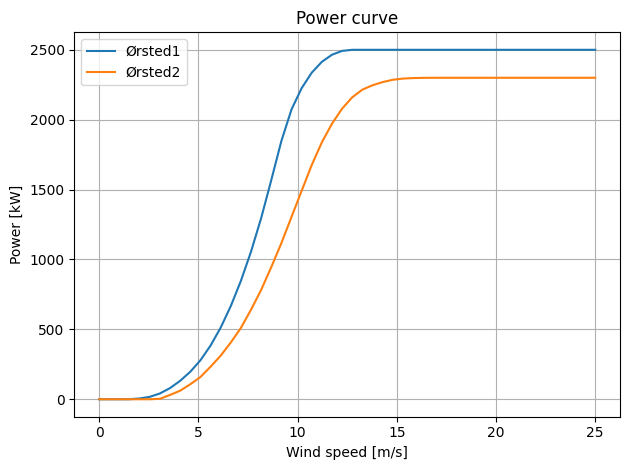

In [5]:
u = np.linspace(0,25)

for t in [0,1]:
    plt.plot(u,wts.power(u, type=t)/1000, label=wts.name(t))
setup_plot(xlabel='Wind speed [m/s]', ylabel='Power [kW]', title='Power curve')

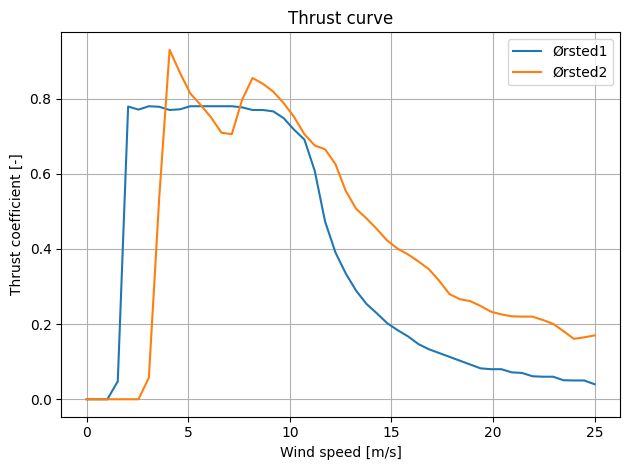

In [6]:
for t in [0,1]:
    plt.plot(u,wts.ct(u, type=t), label=wts.name(t))
setup_plot(xlabel='Wind speed [m/s]', ylabel='Thrust coefficient [-]', title='Thrust curve')

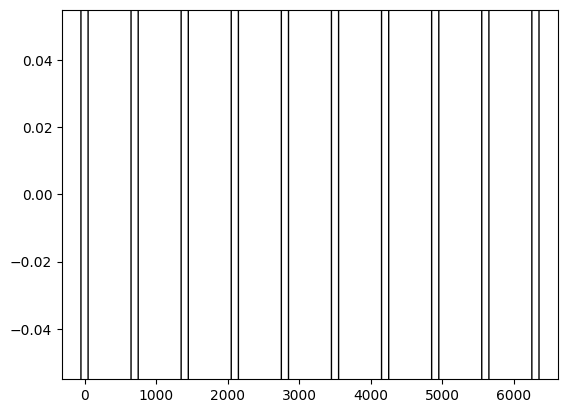

In [7]:
u0 = [6, 7, 8, 9, 10, 11, 12, 13, 14] # [m/s]
wd = 270 # [deg]
ti0 = [0.09, 0.1, 0.11, 0.12, 0.14, 0.15, 0.16, 0.17, 0.18] # [-]

y, x = [v.flatten() for v in np.meshgrid(np.arange(1) * 100 * 7, np.arange(10) * 100 * 7)]
wt1.plot(x, y)

In [8]:
site = UniformSite(shear=PowerShear(h_ref=90, alpha=.1))

wfm = Nygaard_2022(site, wt1)
sim_res = wfm(x, y, ws=u0, wd=wd, TI=ti0)
#sim_res.WS_eff
#sim_res.Power /1000

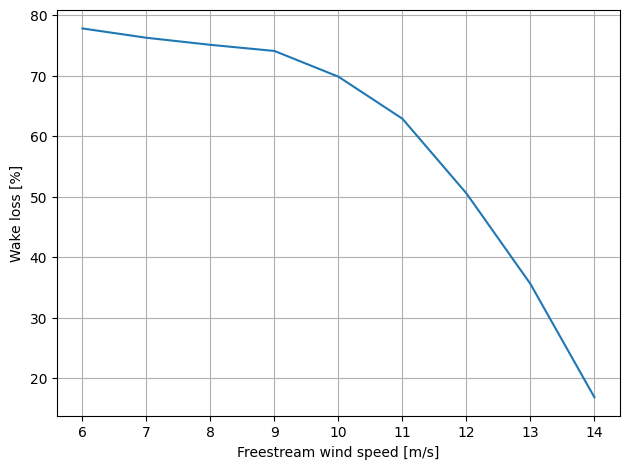

In [9]:
((1-(sim_res.Power.mean('wt') / sim_res.Power.max('wt')))*100).plot()
setup_plot(ylabel='Wake loss [%]', xlabel='Freestream wind speed [m/s]')

'\n# Extract the wind speed after the last row of turbines\naverage_ws_after_last_row = wake_map.WS_eff.sel(x=slice(x[-1] + 1, None)).mean().item()\nx_value_of_average_ws = wake_map.WS_eff.sel(x=slice(x[-1] + 1, None)).mean(dim=\'y\').idxmax(\'x\').item()\n\nprint(f"Average wind speed after the last row of turbines: {average_ws_after_last_row:.2f} m/s")\nprint(f"x-value at which this occurs: {x_value_of_average_ws:.2f} m")"\n'

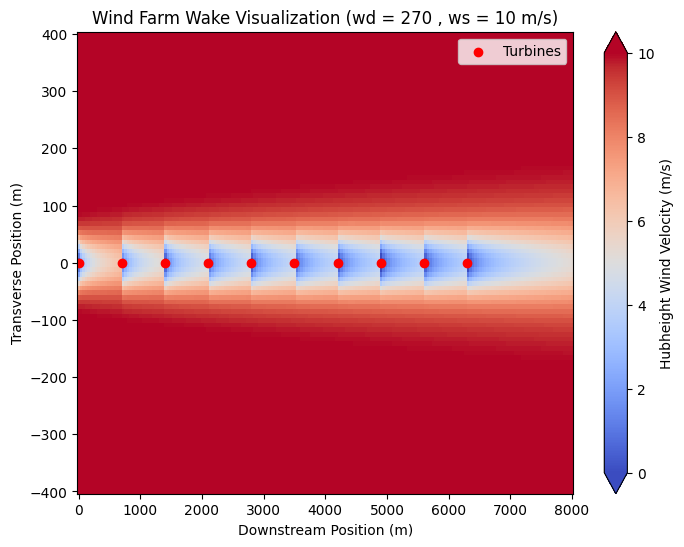

In [10]:
# --- Wake Visualization ---
fig, ax = plt.subplots(figsize=(8, 6))

# Compute the flow map and grid
flow_map_grid = HorizontalGrid(x=np.linspace(0, 8000, 200), y=np.linspace(-400, 400, 100))
flow_map = sim_res.flow_map(grid=flow_map_grid)
wake_map = flow_map.sel(wd=wd, ws=10, method="nearest")
vmin, vmax = 0, 10

wake_map.WS_eff.plot(ax=ax, cmap="coolwarm", vmin=vmin, vmax=vmax, cbar_kwargs={'label': 'Hubheight Wind Velocity (m/s)'})

# Plot turbine positions
ax.scatter(x, y, color="red", marker="o", label="Turbines")
ax.set_title("Wind Farm Wake Visualization (wd = " + str(wd) + " , ws = " + str(10) + " m/s)")
ax.set_xlabel("Downstream Position (m)")
ax.set_ylabel("Transverse Position (m)")
ax.legend()

"""
# Extract the wind speed after the last row of turbines
average_ws_after_last_row = wake_map.WS_eff.sel(x=slice(x[-1] + 1, None)).mean().item()
x_value_of_average_ws = wake_map.WS_eff.sel(x=slice(x[-1] + 1, None)).mean(dim='y').idxmax('x').item()

print(f"Average wind speed after the last row of turbines: {average_ws_after_last_row:.2f} m/s")
print(f"x-value at which this occurs: {x_value_of_average_ws:.2f} m")"
"""

In [11]:
x_target = 7*100*9 # Replace with your desired x-coordinate
velocity_at_x = wake_map.WS_eff.sel(x=x_target, method="nearest").mean(dim="y").item()
print(f"Wind velocity at x = {x_target} m: {velocity_at_x:.2f} m/s")

Wind velocity at x = 6300 m: 8.75 m/s
